# Predicting Bifurcation of Mechanical Systems using Reservoir Computing

This notebook demonstrates **bifurcation embedding** of electrical resistance in Pneumatic Artificial Muscle (PAM) systems using Echo State Networks (ESN). The method captures complex bifurcation patterns and nonlinear dynamics in soft mechanical actuators.

## Overview
- **Objective**: Predict bifurcation patterns in PAM electrical resistance
- **Input signals**: Pressure control, Applied load
- **Output**: Electrical resistance prediction with bifurcation embedding
- **Method**: Echo State Network with Ridge regression readout
- **Focus**: Bifurcation prediction and nonlinear dynamics modeling

## 1. Import Libraries and Initialize ESN Classes

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import importlib
from matplotlib.lines import Line2D

# Import and reload ESN classes
import ESNClasses
importlib.reload(ESNClasses)
from ESNClasses import *

## 2. Load PAM Experimental Data

In [2]:
# Load PAM experimental data
PAM_data_path = 'data/PAM1_BifurcationData/PAM_timeseries_load_change.txt'
PAM_data = np.loadtxt(PAM_data_path)

# Data column indices (multiplexing configuration)
resistance_column = 21          # Electrical resistance measurements
pressure_column = 7              # Pressure control signal
length_column = 4               # PAM length measurements
load_measurement_column = 6     # Applied load measurements
measured_pressure_column = 23   # Actual pressure measurements

delta_load_sine = 5  # Load change for sine wave
nb_measures_sine = 2000 # Number of measurements for sine wave segment
nb_measures = 2000  # Total number of measurements to consider

print(f"Data shape: {PAM_data.shape}")
print(f"Successfully loaded PAM experimental data")

Data shape: (64000, 33)
Successfully loaded PAM experimental data


## 3. Initialize ESN Components and Run the ESN

Create the three main components of the ESN: input layer, reservoir, and output layer.

=== ESN Bifurcation Analysis ===
Reservoir dimension: 1000
Spectral radius: 0.95
Training loads: 160N, 220N

=== Training Phase ===
Training on sine data at load = 160N
Training on sine data at load = 220N


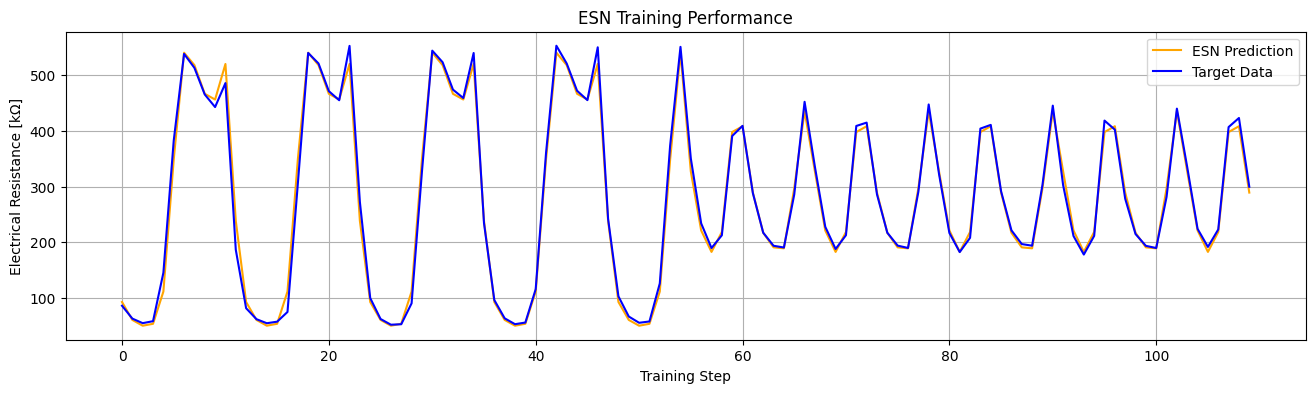

Training completed with 110 samples

=== Prediction Phase ===


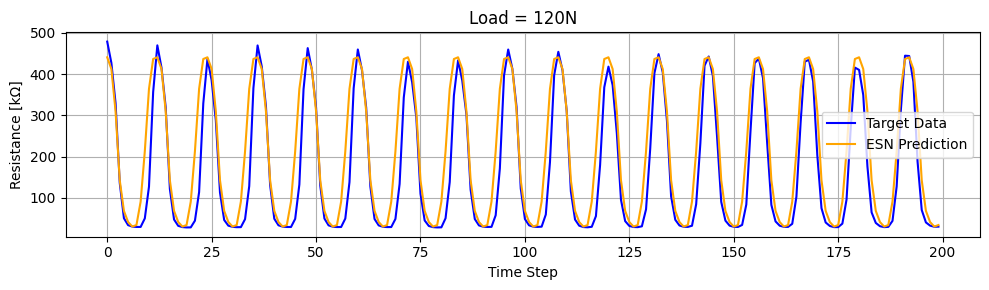

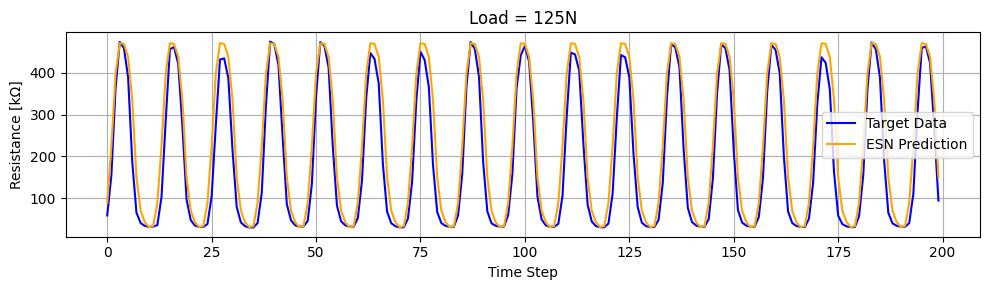

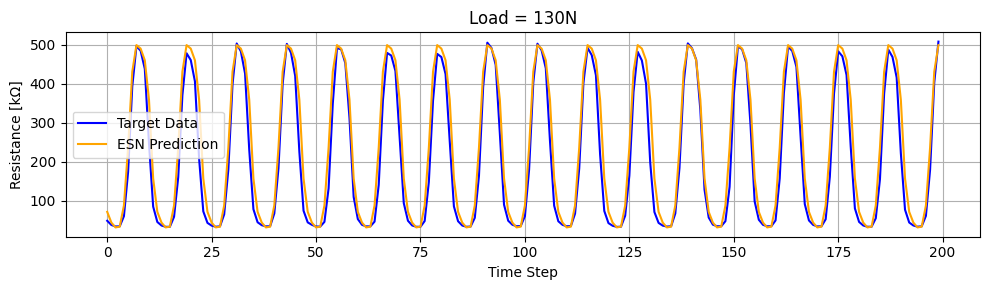

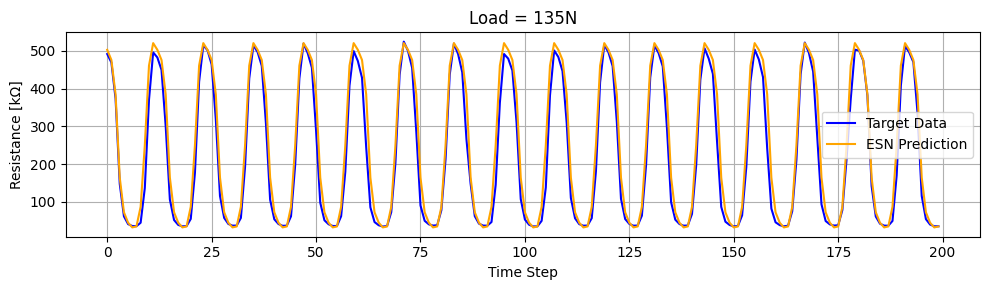

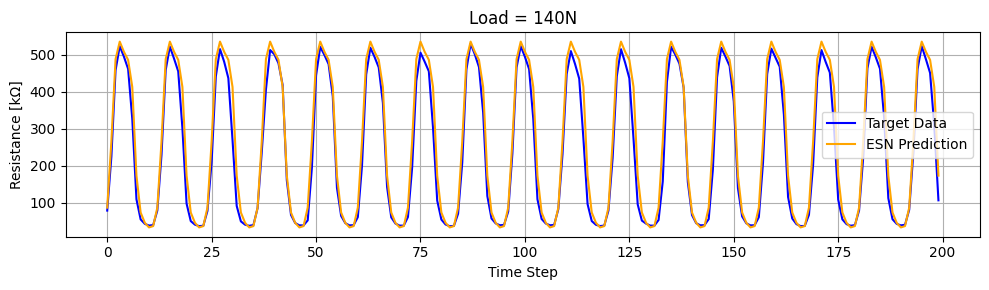

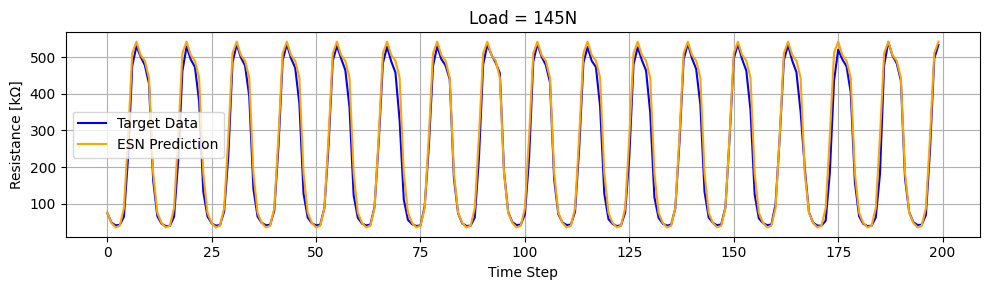

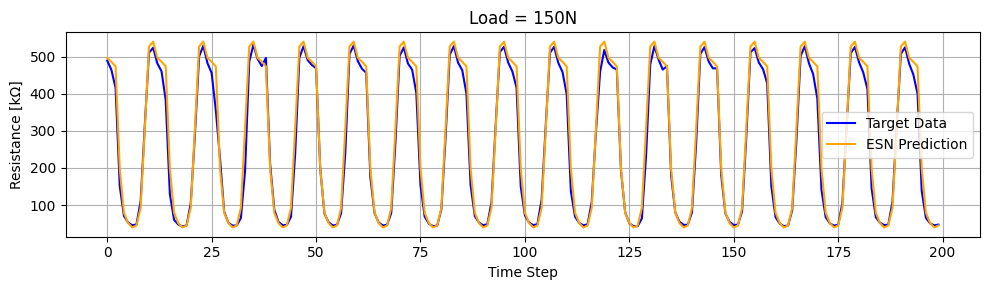

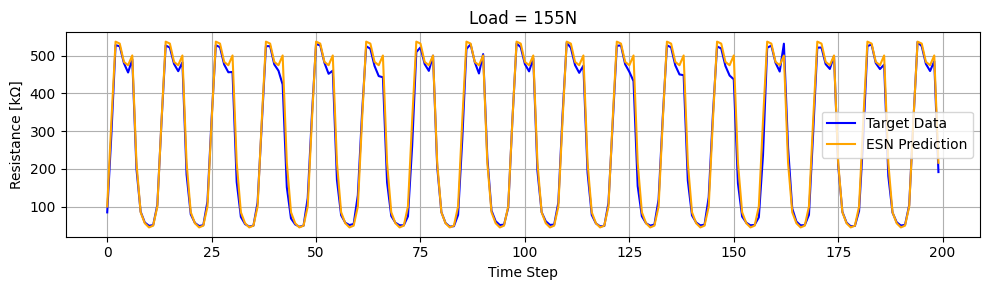

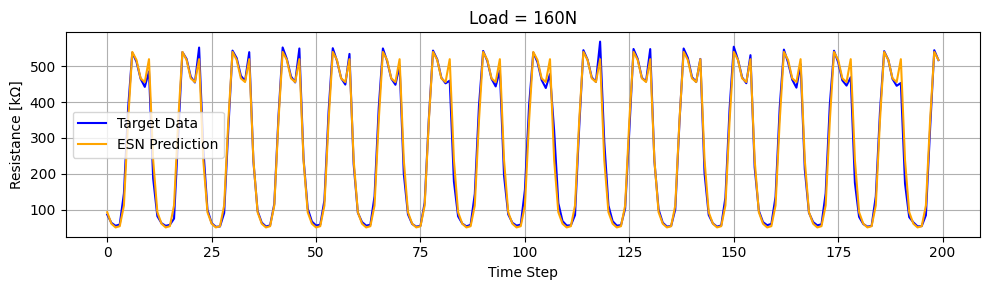

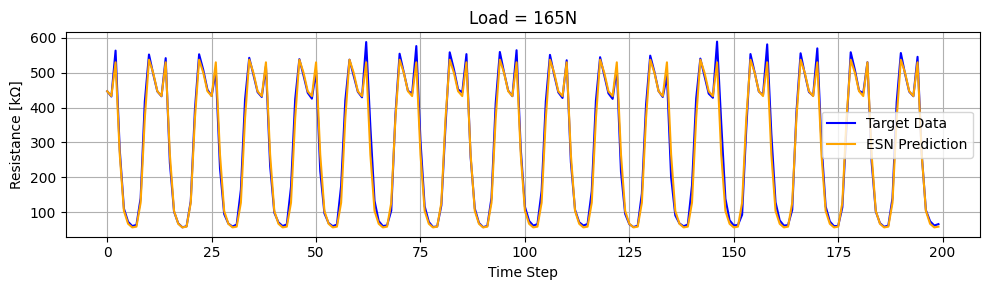

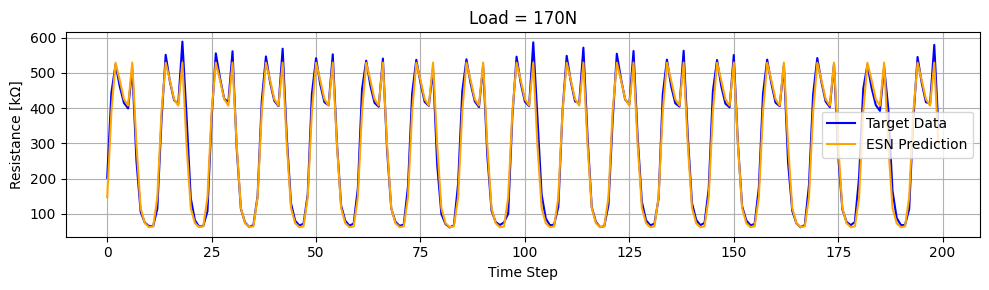

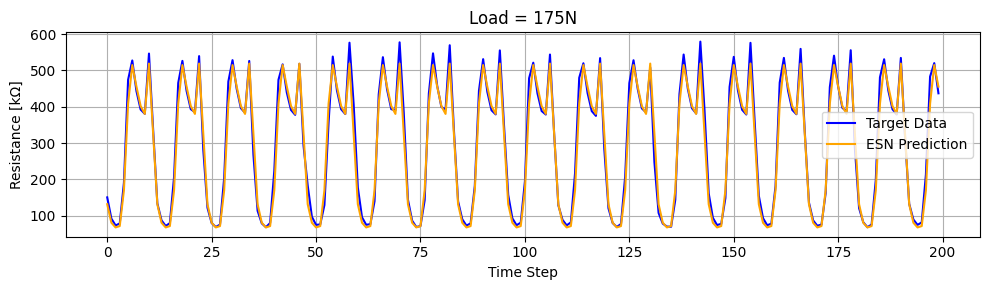

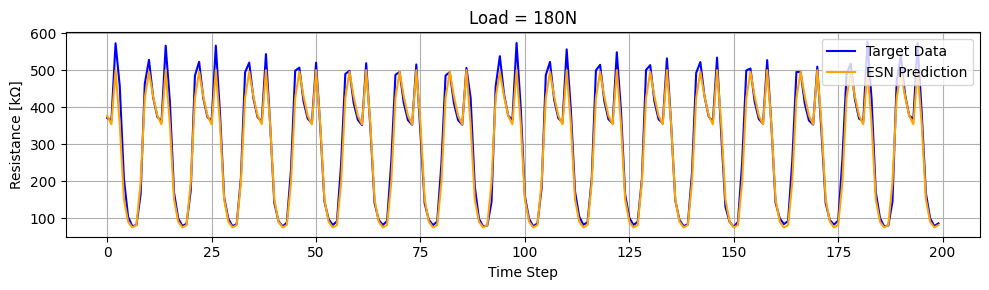

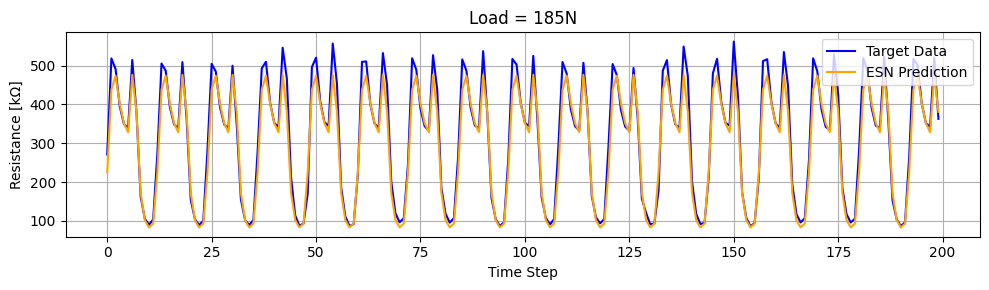

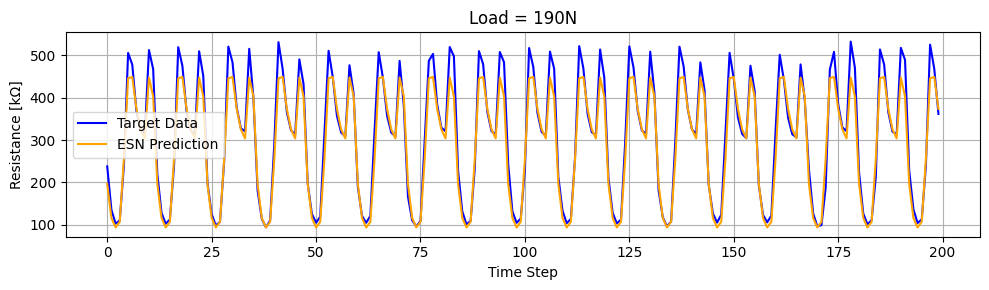

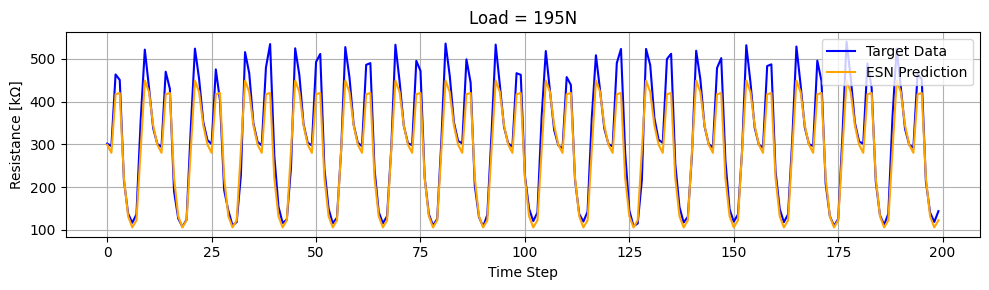

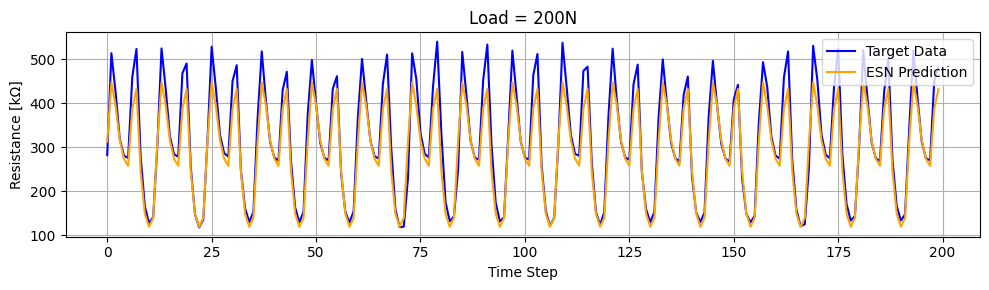

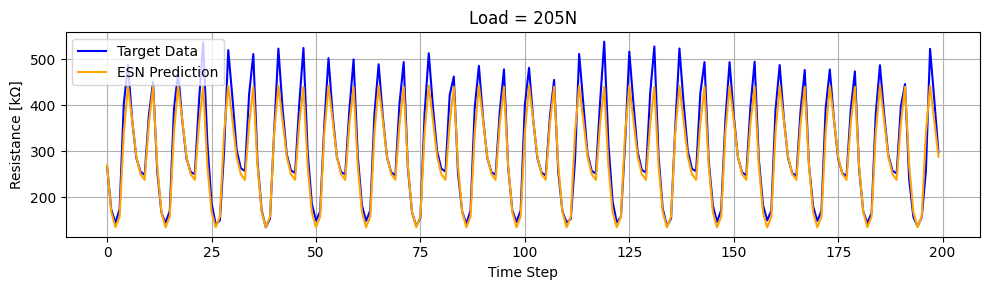

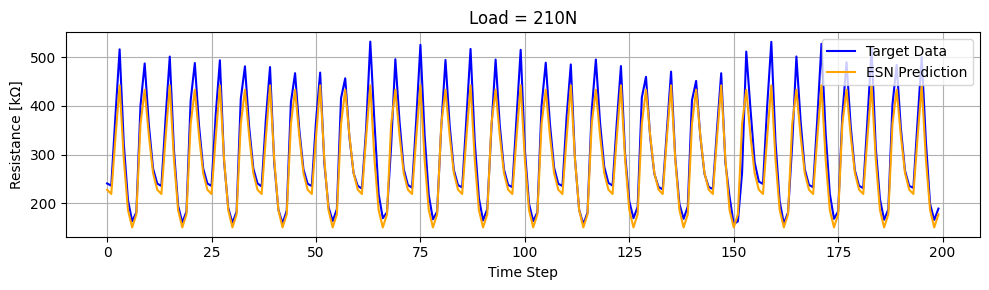

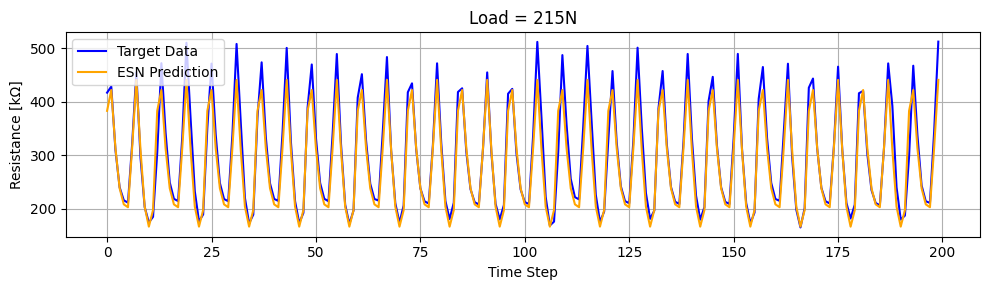

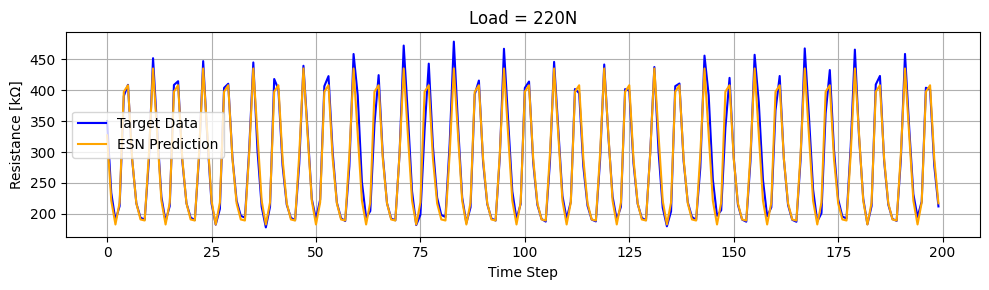

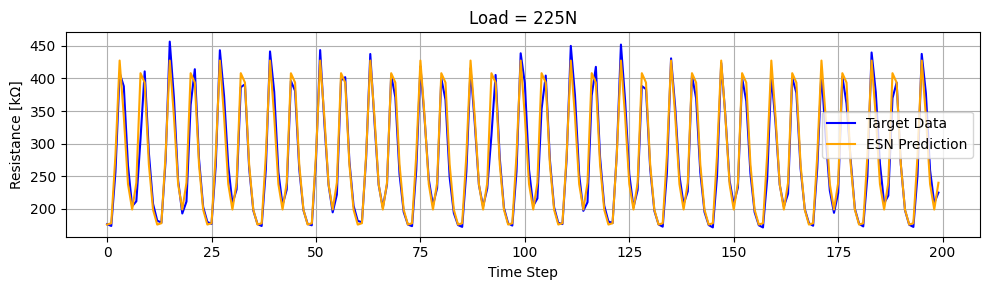

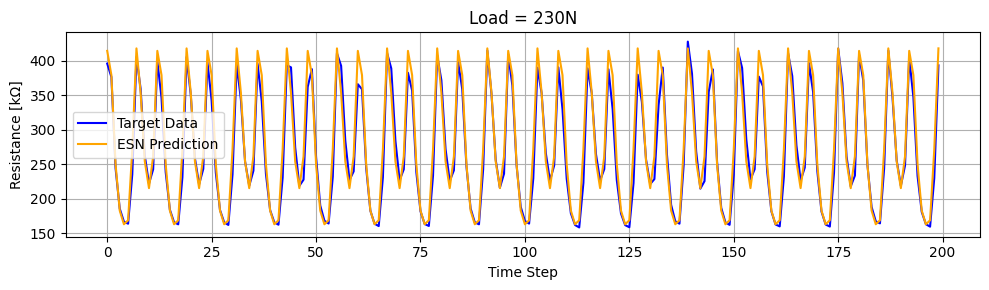

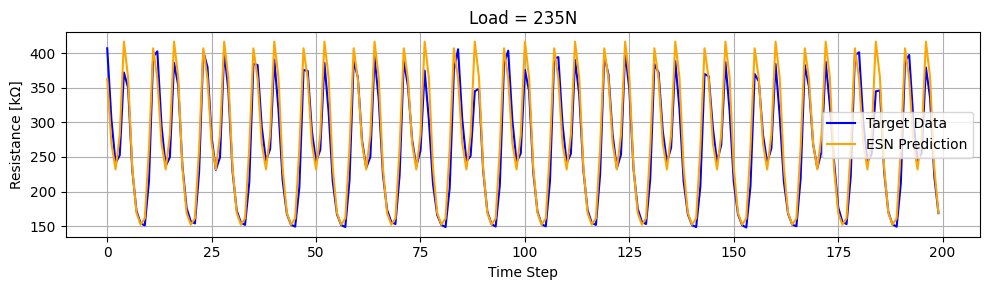

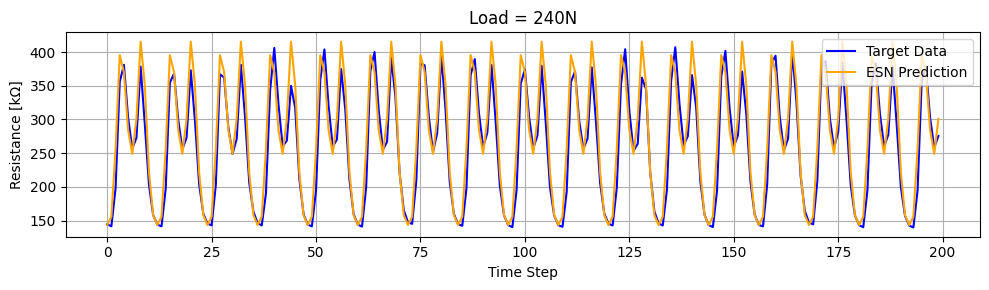

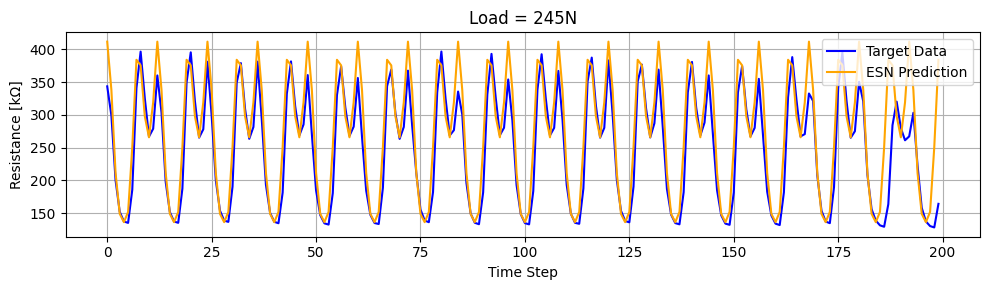

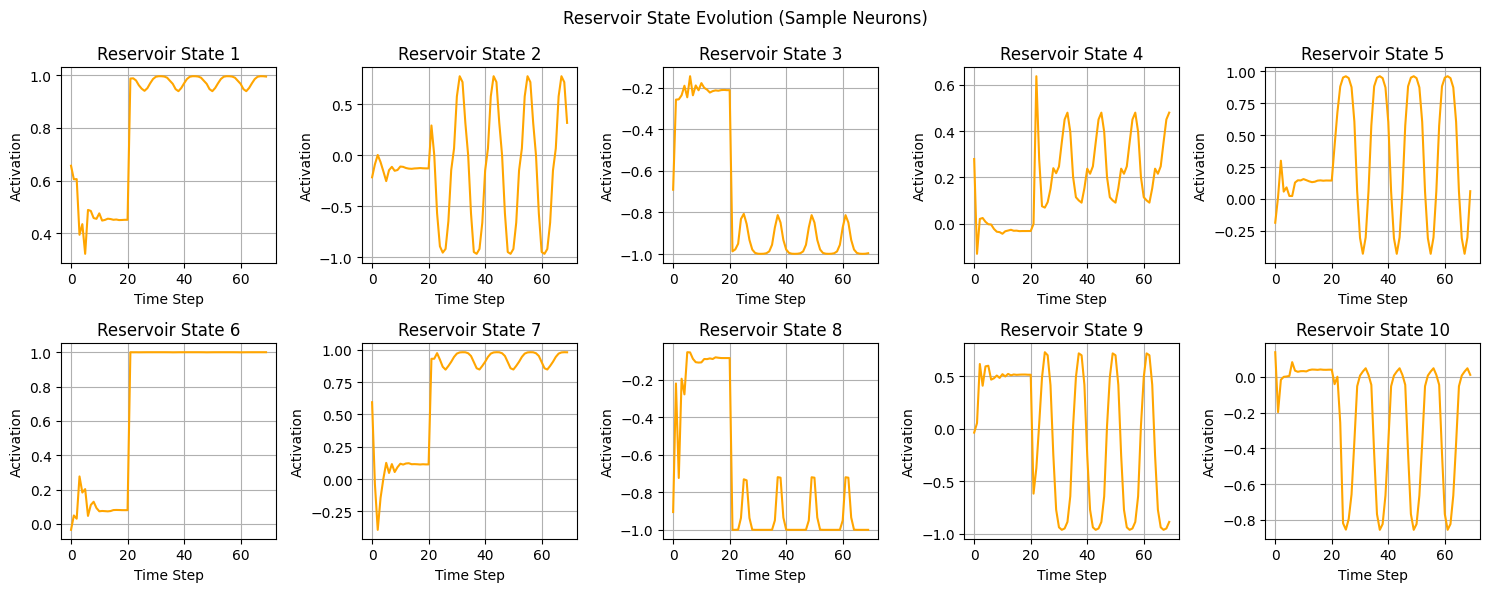

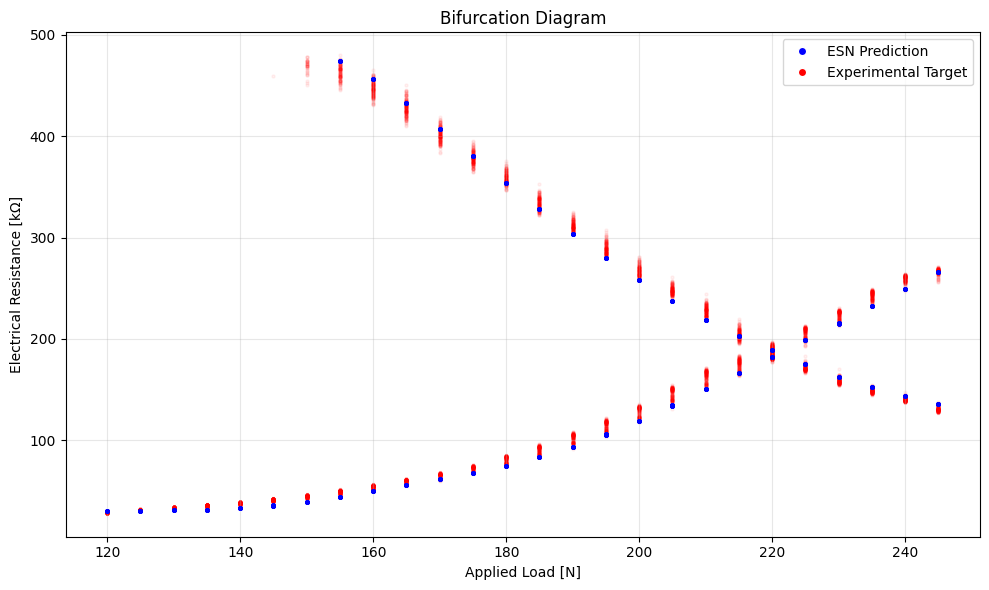

=== ESN Bifurcation Analysis Completed ===
Analyzed loads from 120N to 245N in 5N increments
ESN configuration: 1000 neurons, ρ=0.95
Training: 160N and 220N conditions


In [6]:
# === ESN Training and Prediction with Bifurcation Analysis ===
import numpy as np

# Use PAM experimental data
PAM_data_source = PAM_data

# === Hyperparameters (Direct Values) ===
regularization_lambda = 1.0        # Ridge regression regularization parameter
spectral_radius_rho = 0.95         # Reservoir spectral radius
leakage_rate = 1.0                 # Leaky integrator rate  
sparsity_level = 1.0               # Matrix sparsity (1.0 = fully connected)
shrinking_factor = 1.0             # State shrinking factor
divide_states = False              # Whether to divide reservoir states
input_scaling = 2.5                # Input weight scaling
reservoir_scaling = 1.0            # Reservoir weight scaling  
bias_scaling = 0.55                # Bias weight scaling
output_scaling = 0.1               # Output weight bound
win_factor = 1                     # Input weight factor
wnet_factor = 1                    # Network weight factor
bias_factor = 1                    # Bias factor
beta_value = 0                     # Input processing parameter

# Training configuration
washout_time = 20                  # Washout steps
training_time = 80                 # Training time steps
first_training_load = 160          # First training load [N]
second_training_load = 220         # Second training load [N]
washout_input_scaling = 0.0        # Washout input scaling
heat_up_time = 25                  # Heat-up time for predictions
prediction_time = 200              # Prediction time steps
training_shift = 0                 # Training data shift

# System bounds
load_min_bound = 100               # Minimum load value [N]
load_max_bound = 245               # Maximum load value [N]

# Network dimensions
esn_dimension = 1000               # ESN reservoir size
input_dimension = 2                # Input dimension [pressure, load]
output_dimension = 1               # Output dimension [resistance]

# Data processing parameters
delta_load_sine = 5                # Load increment for sine data
nb_measurements_sine = 2000        # Number of measurements per sine segment
nb_measurements = 2000             # Total measurements to use

print("=== ESN Bifurcation Analysis ===")
print(f"Reservoir dimension: {esn_dimension}")
print(f"Spectral radius: {spectral_radius_rho}")
print(f"Training loads: {first_training_load}N, {second_training_load}N")

# === Initialize Bifurcation Results Storage ===
bifurcation_results = {}

# === Initialize Random Number Generator ===
rng_seed = np.random.default_rng(1234)

# === Create ESN Components ===
initial_reservoir_state = rng_seed.uniform(low=0, high=0, size=(esn_dimension,))

# Input layer: maps inputs to reservoir
input_layer_esn = Linear(
    input_dimension, esn_dimension, 
    bound=input_scaling,
    LowboundBias=-input_scaling, 
    HighboundBias=input_scaling, 
    rnd=rng_seed
)

# Reservoir network
reservoir_network = ESN(
    dim=esn_dimension,
    sr=spectral_radius_rho,
    a=leakage_rate,
    f=np.tanh,
    p=sparsity_level,
    init_state=initial_reservoir_state,
    rnd=rng_seed,
    normalize=True,
    wpFactor=0,
    wnetFactor=wnet_factor,
    knet=reservoir_scaling,
    kbias=bias_scaling,
    theBiasFactor=bias_factor,
    shrinkingFactor=shrinking_factor,
    divideStates=divide_states
)

# Output layer: Ridge regression readout
output_layer_esn = RidgeReadout(
    esn_dimension, output_dimension, 
    bound=output_scaling,
    LowboundBias=-1, 
    HighboundBias=1,
    lmbd=regularization_lambda, 
    rnd=rng_seed
)

# === Training Data Configuration ===
training_conditions = [(first_training_load, 'sine'), (second_training_load, 'sine')]
total_training_time = washout_time + training_time

print("\n=== Training Phase ===")

# === ESN Training (Open-Loop) ===
reservoir_states_training = []
target_outputs_training = []

# Data column indices
resistance_columns = [21]          # Electrical resistance
pressure_columns = [7]             # Pressure control signals  
length_columns = [22]              # PAM length
load_measurement_columns = [24]    # Load measurements
measured_pressure_columns = [23]   # Measured pressure

for load_value, data_type in training_conditions:
    column_index = 0  # Use first column for sine data
    print(f"Training on {data_type} data at load = {load_value}N")
    
    # Extract data segment
    start_index = int(((load_value - 100) / delta_load_sine) * nb_measurements_sine)
    electrical_resistance = PAM_data_source[start_index:(start_index + nb_measurements), resistance_columns[column_index]] / 1e3
    pressure_signal = PAM_data_source[start_index:(start_index + nb_measurements), pressure_columns[column_index]]
    measured_pressure = PAM_data_source[start_index:(start_index + nb_measurements), measured_pressure_columns[column_index]]
    length_signal = PAM_data_source[start_index:(start_index + nb_measurements), length_columns[column_index]]
    load_measurement = PAM_data_source[start_index:(start_index + nb_measurements), load_measurement_columns[column_index]]
    
    # Normalize signals for ESN processing
    resistance_normalized = (electrical_resistance - np.min(electrical_resistance)) / (np.max(electrical_resistance) - np.min(electrical_resistance))
    pressure_normalized = (pressure_signal - np.min(pressure_signal)) / (np.max(pressure_signal) - np.min(pressure_signal))
    measured_pressure_normalized = (measured_pressure - np.min(measured_pressure)) / (np.max(measured_pressure) - np.min(measured_pressure))
    length_normalized = (length_signal - np.min(length_signal)) / (np.max(length_signal) - np.min(length_signal))
    
    load_normalized = (load_value - load_min_bound) / (load_max_bound - load_min_bound)
    
    # Washout phase: stabilize reservoir dynamics
    for t in range(washout_time):
        washout_input = np.random.uniform(-washout_input_scaling, washout_input_scaling, size=input_dimension)
        reservoir_input = input_layer_esn(washout_input, beta=0, winFactor=win_factor)
        reservoir_network.step(reservoir_input, p=0)
    
    # Training phase: collect data
    for t in range(training_shift, training_shift + training_time):
        current_input = [pressure_normalized[t], load_normalized]
        
        reservoir_input = input_layer_esn(current_input, beta=beta_value, winFactor=win_factor)
        reservoir_network.step(reservoir_input, p=0)
        
        # Collect training data after heat-up period
        if t >= heat_up_time:
            reservoir_states_training.append(np.copy(reservoir_network.x))
            target_outputs_training.append([electrical_resistance[t]])

# Convert to numpy arrays and train output layer
reservoir_states_training = np.array(reservoir_states_training)
target_outputs_training = np.array(target_outputs_training)
output_layer_esn.train(reservoir_states_training, target_outputs_training)

# Visualize training performance
training_predictions = output_layer_esn(reservoir_states_training)[:,0]
training_targets = target_outputs_training[:,0]

plt.figure(figsize=(16, 4))
plt.plot(training_predictions, label='ESN Prediction', color='orange')
plt.plot(training_targets, label='Target Data', color='blue')
plt.xlabel('Training Step')
plt.ylabel('Electrical Resistance [kΩ]')
plt.title('ESN Training Performance')
plt.legend()
plt.grid(True)
plt.show()

print(f"Training completed with {len(reservoir_states_training)} samples")

# === Testing/Prediction Phase ===
print("\n=== Prediction Phase ===")
bifurcation_results = {}

for load_value in range(120, 250, 5):
    column_index = 0  # Use first column for sine data
    
    # Extract test data segment
    start_index = int(((load_value - 100) / delta_load_sine) * nb_measurements_sine)
    electrical_resistance = PAM_data_source[start_index:(start_index + nb_measurements), resistance_columns[column_index]] / 1e3
    pressure_signal = PAM_data_source[start_index:(start_index + nb_measurements), pressure_columns[column_index]]
    measured_pressure = PAM_data_source[start_index:(start_index + nb_measurements), measured_pressure_columns[column_index]]
    length_signal = PAM_data_source[start_index:(start_index + nb_measurements), length_columns[column_index]]
    load_measurement = PAM_data_source[start_index:(start_index + nb_measurements), load_measurement_columns[column_index]]
    
    # Normalize test signals
    resistance_normalized = (electrical_resistance - np.min(electrical_resistance)) / (np.max(electrical_resistance) - np.min(electrical_resistance))
    pressure_normalized = (pressure_signal - np.min(pressure_signal)) / (np.max(pressure_signal) - np.min(pressure_signal))
    measured_pressure_normalized = (measured_pressure - np.min(measured_pressure)) / (np.max(measured_pressure) - np.min(measured_pressure))
    length_normalized = (length_signal - np.min(length_signal)) / (np.max(length_signal) - np.min(length_signal))
    
    load_normalized = (load_value - load_min_bound) / (load_max_bound - load_min_bound)
    
    # Initialize prediction arrays
    resistance_predictions = np.zeros(prediction_time)
    length_predictions = np.zeros(prediction_time)
    pressure_predictions = np.zeros(prediction_time)
    load_predictions = np.zeros(prediction_time)
    
    reservoir_state_evolution = []
    
    # Washout phase for prediction
    for t in range(washout_time):
        washout_input = np.random.uniform(-washout_input_scaling, washout_input_scaling, size=input_dimension)
        reservoir_network.step(input_layer_esn(washout_input, beta=0, winFactor=win_factor), p=0)
        reservoir_state_evolution.append(reservoir_network.x[80:90].copy())
    
    # Prediction phase
    for t in range(heat_up_time + prediction_time):
        if t < 50:  # Track additional reservoir states
            reservoir_state_evolution.append(reservoir_network.x[80:90].copy())
        
        current_input = [pressure_normalized[t], load_normalized]
        
        reservoir_input = input_layer_esn(current_input, beta=beta_value, winFactor=win_factor)
        reservoir_network.step(reservoir_input, p=0)
        
        # Generate predictions
        resistance_output = output_layer_esn(np.copy(reservoir_network.x))[0][0]
        
        # Store predictions after heat-up period
        if t >= heat_up_time:
            resistance_predictions[t - heat_up_time] = resistance_output
    
    # Extract target values for comparison
    resistance_targets = electrical_resistance[heat_up_time:heat_up_time + prediction_time]
    
    # Store bifurcation data
    bifurcation_results = createMyBifurcationDiagram(resistance_predictions, bifurcation_results, load_value)

    # Visualization for individual loads
    
    fig, ax = plt.subplots(figsize=(10, 3))
    ax.plot(range(prediction_time), resistance_targets, label='Target Data', color='blue')
    ax.plot(range(prediction_time), resistance_predictions, label='ESN Prediction', color='orange')
    ax.set_xlabel('Time Step')
    ax.set_ylabel('Resistance [kΩ]')
    ax.set_title(f"Load = {load_value}N")
    ax.legend()
    ax.grid(True)
    plt.tight_layout()
    plt.show()
    
# Convert reservoir states to numpy array for visualization
reservoir_states_array = np.array(reservoir_state_evolution)

# Visualize reservoir state dynamics

num_nodes = reservoir_states_array.shape[1]  # Should be 10
rows, cols = 2, 5
fig, axs = plt.subplots(rows, cols, figsize=(15, 6))
axs = axs.flatten()

for i in range(num_nodes):
    axs[i].plot(reservoir_states_array[:, i], color='orange')
    axs[i].set_title(f'Reservoir State {i+1}')
    axs[i].set_xlabel("Time Step")
    axs[i].set_ylabel("Activation")
    axs[i].grid(True)

plt.suptitle('Reservoir State Evolution (Sample Neurons)')
plt.tight_layout()
plt.show()

# === Bifurcation Diagram Visualization ===

fig, ax = plt.subplots(figsize=(10, 6))

# Plot ESN bifurcation predictions
plotBifurcation(bifurcation_results, ax=ax)

# Plot experimental target bifurcation data
resistance_multiplexing = resistance_columns
target_colors = ['red'] * len(resistance_multiplexing)
target_labels = ['Experimental Data']

load_values = list(range(120, 250, 5))

plot_target_bifurcation(
    ax,
    PAM_data_source,
    resistance_multiplexing,
    load_values,
    nb_measurements,
    delta_load_sine,
    nb_measurements
)
    
# Create custom legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='ESN Prediction',
            markerfacecolor='blue', markersize=6),
    Line2D([0], [0], marker='o', color='w', label='Experimental Target',
            markerfacecolor='red', markersize=6)
]
ax.legend(handles=legend_elements)

# Configure bifurcation plot
ax.set_xlabel('Applied Load [N]')
ax.set_ylabel('Electrical Resistance [kΩ]')
ax.set_title('Bifurcation Diagram')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("=== ESN Bifurcation Analysis Completed ===")
print(f"Analyzed loads from 120N to 245N in 5N increments")
print(f"ESN configuration: {esn_dimension} neurons, ρ={spectral_radius_rho}")
print(f"Training: {first_training_load}N and {second_training_load}N conditions")

## 4. Performance Analysis and Training Evaluation

=== ESN Performance Analysis ===
Analyzing prediction performance across 26 load conditions

=== ESN Performance Summary ===
Mean RMSE: 33.4395 ± 12.8424 kΩ
Mean NRMSE: 0.0821 ± 0.0325
Median NRMSE: 0.0782
Min NRMSE: 0.0397
Max NRMSE: 0.1672
Load range tested: 120N - 245N
Number of test conditions: 26

=== ESN Performance Summary ===
Mean RMSE: 33.4395 ± 12.8424 kΩ
Mean NRMSE: 0.0821 ± 0.0325
Median NRMSE: 0.0782
Min NRMSE: 0.0397
Max NRMSE: 0.1672
Load range tested: 120N - 245N
Number of test conditions: 26


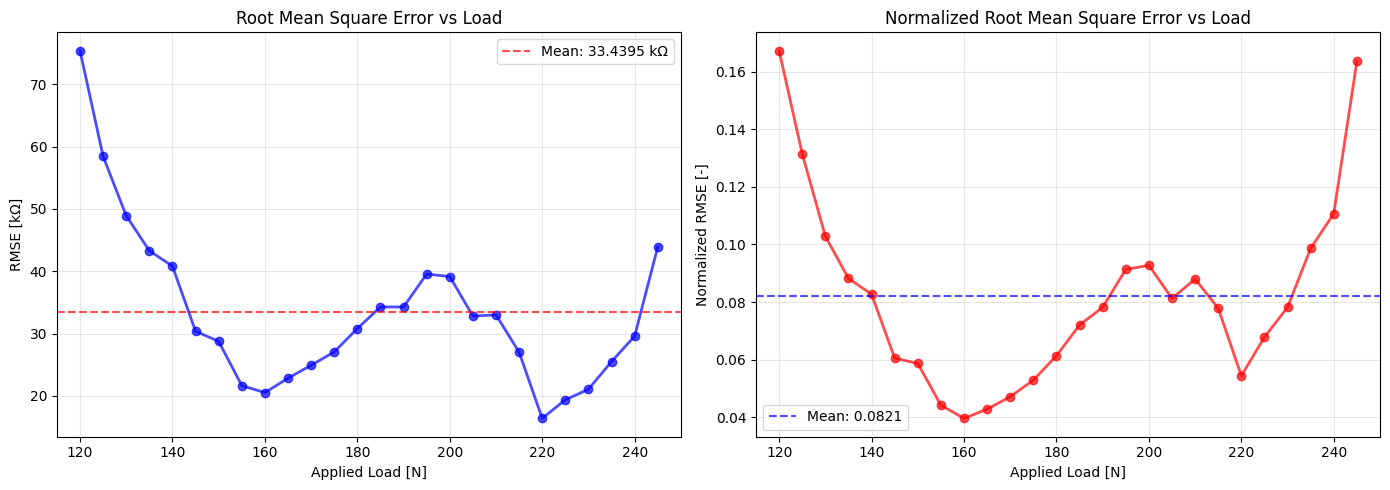


=== Analysis Complete ===
ESN demonstrates robust performance across the tested load range
Bifurcation embedding successfully captured in 26 load conditions


In [8]:
# === Calculate Performance Metrics from Bifurcation Analysis ===

# Collect all prediction performance data from the load range tested
load_range_tested = list(range(120, 250, 5))
rmse_values = []
nrmse_values = []

print("=== ESN Performance Analysis ===")
print(f"Analyzing prediction performance across {len(load_range_tested)} load conditions")

# Recalculate performance for each load condition
for load_value in load_range_tested:
    column_index = 0
    
    # Extract test data segment (same as in main loop)
    start_index = int(((load_value - 100) / delta_load_sine) * nb_measurements_sine)
    electrical_resistance = PAM_data_source[start_index:(start_index + nb_measurements), resistance_columns[column_index]] / 1e3
    pressure_signal = PAM_data_source[start_index:(start_index + nb_measurements), pressure_columns[column_index]]
    
    # Normalize signals
    resistance_normalized = (electrical_resistance - np.min(electrical_resistance)) / (np.max(electrical_resistance) - np.min(electrical_resistance))
    pressure_normalized = (pressure_signal - np.min(pressure_signal)) / (np.max(pressure_signal) - np.min(pressure_signal))
    load_normalized = (load_value - load_min_bound) / (load_max_bound - load_min_bound)
    
    # Quick prediction for this load (simplified version)
    resistance_predictions = np.zeros(prediction_time)
    
    # Reset reservoir state
    rng_temp = np.random.default_rng(1234)  # Ensure reproducibility
    reservoir_network.x = rng_temp.uniform(low=0, high=0, size=(esn_dimension,))
    
    # Washout
    for t in range(washout_time):
        washout_input = np.random.uniform(-washout_input_scaling, washout_input_scaling, size=input_dimension)
        reservoir_network.step(input_layer_esn(washout_input, beta=0, winFactor=win_factor), p=0)
    
    # Prediction
    for t in range(heat_up_time + prediction_time):
        current_input = [pressure_normalized[t], load_normalized]
        reservoir_input = input_layer_esn(current_input, beta=beta_value, winFactor=win_factor)
        reservoir_network.step(reservoir_input, p=0)
        
        if t >= heat_up_time:
            resistance_output = output_layer_esn(np.copy(reservoir_network.x))[0][0]
            resistance_predictions[t - heat_up_time] = resistance_output
    
    # Calculate performance metrics
    resistance_targets = electrical_resistance[heat_up_time:heat_up_time + prediction_time]
    
    # RMSE calculation
    mse = np.mean((resistance_predictions - resistance_targets)**2)
    rmse = np.sqrt(mse)
    
    # NRMSE calculation
    target_range = np.max(resistance_targets) - np.min(resistance_targets)
    nrmse = rmse / target_range if target_range > 0 else 0
    
    rmse_values.append(rmse)
    nrmse_values.append(nrmse)

# Convert to numpy arrays
rmse_values = np.array(rmse_values)
nrmse_values = np.array(nrmse_values)

# Calculate global statistics
mean_rmse = np.mean(rmse_values)
std_rmse = np.std(rmse_values)
mean_nrmse = np.mean(nrmse_values)
std_nrmse = np.std(nrmse_values)
median_nrmse = np.median(nrmse_values)

print("\n=== ESN Performance Summary ===")
print(f"Mean RMSE: {mean_rmse:.4f} ± {std_rmse:.4f} kΩ")
print(f"Mean NRMSE: {mean_nrmse:.4f} ± {std_nrmse:.4f}")
print(f"Median NRMSE: {median_nrmse:.4f}")
print(f"Min NRMSE: {np.min(nrmse_values):.4f}")
print(f"Max NRMSE: {np.max(nrmse_values):.4f}")
print(f"Load range tested: {min(load_range_tested)}N - {max(load_range_tested)}N")
print(f"Number of test conditions: {len(load_range_tested)}")

# Plot performance metrics
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# RMSE vs Load
ax1.plot(load_range_tested, rmse_values, 'bo-', linewidth=2, markersize=6, alpha=0.7)
ax1.set_xlabel('Applied Load [N]')
ax1.set_ylabel('RMSE [kΩ]')
ax1.set_title('Root Mean Square Error vs Load')
ax1.grid(True, alpha=0.3)
ax1.set_xlim(min(load_range_tested)-5, max(load_range_tested)+5)

# Add mean line
ax1.axhline(y=mean_rmse, color='red', linestyle='--', alpha=0.7, label=f'Mean: {mean_rmse:.4f} kΩ')
ax1.legend()

# NRMSE vs Load
ax2.plot(load_range_tested, nrmse_values, 'ro-', linewidth=2, markersize=6, alpha=0.7)
ax2.set_xlabel('Applied Load [N]')
ax2.set_ylabel('Normalized RMSE [-]')
ax2.set_title('Normalized Root Mean Square Error vs Load')
ax2.grid(True, alpha=0.3)
ax2.set_xlim(min(load_range_tested)-5, max(load_range_tested)+5)

# Add mean line
ax2.axhline(y=mean_nrmse, color='blue', linestyle='--', alpha=0.7, label=f'Mean: {mean_nrmse:.4f}')
ax2.legend()

plt.tight_layout()
plt.show()

print(f"\n=== Analysis Complete ===")
print(f"ESN demonstrates robust performance across the tested load range")
print(f"Bifurcation embedding successfully captured in {len(bifurcation_results)} load conditions")